In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from collections import defaultdict #data colector

#Surprise: https://surprise.readthedocs.io/en/stable/
import surprise

from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV

  ##CrossValidation
from surprise.model_selection import cross_validate


  ##Matrix Factorization Algorithms
from surprise import SVD
from surprise import NMF

np.random.seed(42) # replicating results

In [2]:
ratings = pd.read_csv('/Users/test1/Desktop/week_11/data/ratings.csv')
movies = pd.read_csv('/Users/test1/Desktop/week_11/data/movies.csv')

## Data Pre-Processing
#### Filtering Data Set

Firstly, it is essential to filter out movies and users with low exposure to remove some of the noise from outliers. According to the official MovieLens documentation, all selected users have rated at least 20 movies in the data set. However, the following code filters out the movies and users based on an arbitrary threshold and creates a new data frame ratings_flrd_df. Moreover, the chunk also prints the value of deleted movies with new and old dimensions.



In [3]:
min_movie_ratings = 2 #a movie has was rated at least 
min_user_ratings =  5 #a user rated movies at least


ratings_flrd_df = ratings.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_movie_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)



"{0} movies deleted; all movies are now rated at least: {1} times. Old dimensions: {2}; New dimensions: {3}"\
.format(len(ratings.movieId.value_counts()) - len(ratings_flrd_df.movieId.value_counts())\
        ,min_movie_ratings,ratings.shape, ratings_flrd_df.shape )


'3446 movies deleted; all movies are now rated at least: 2 times. Old dimensions: (100836, 4); New dimensions: (97390, 4)'

## Data Loading

While using Surprise, one can use a bunch of built-in datasets (e.g. Jeseter or even the movielens) parsed by Dataset module.

In [4]:
reader = Reader(rating_scale=(0.5, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(ratings_flrd_df[["userId","movieId","rating"]], reader=reader)

trainset = data.build_full_trainset()

testset = trainset.build_anti_testset()

## Singular Value Decomposition (SVD)

SVD decomposes any matrix into singular vectors and singular values. I

### Number of Factors and RMSE



In [5]:
def rmse_vs_factors(algorithm, data):
  """Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each  factor k in range(1, 101, 1)
  100 values 
  Arg:  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, ii.)  data = surprise.dataset.DatasetAutoFolds
  """
  
  rmse_algorithm = []
  
  for k in range(1, 101, 1):
    algo = algorithm(n_factors = k)
    
    #["test_rmse"] is a numpy array with min accuracy value for each testset
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
    rmse_algorithm.append(loss_fce)
  
  return rmse_algorithm

#0.0015829191458780407

In [6]:
rmse_svd = rmse_vs_factors(SVD,data)
rmse_svd

[0.8640701175512149,
 0.8638769168745929,
 0.8637510800022202,
 0.8647810806707433,
 0.8630269836485123,
 0.8645231696291852,
 0.8637202865052265,
 0.8653130504980988,
 0.8651309812188954,
 0.8639277704232035,
 0.8643845731386314,
 0.8642636198723611,
 0.8636404957627614,
 0.8635472186317541,
 0.8630540896887444,
 0.8646289674927801,
 0.8644148449973146,
 0.8647752962643429,
 0.863489924117179,
 0.863763619597148,
 0.8643895617697609,
 0.8641200537928475,
 0.8646901769902537,
 0.8645757957332838,
 0.8645621484022519,
 0.8643118397484937,
 0.8639517832384407,
 0.8640837187371281,
 0.8648788040001444,
 0.8638063897068632,
 0.8643820853322743,
 0.8645563355224608,
 0.8651725056535128,
 0.8643567704716653,
 0.8656419522972746,
 0.8649302076143298,
 0.8650170850424029,
 0.8645597711881864,
 0.8651011379056058,
 0.8647809429792133,
 0.8661189481648073,
 0.8661791376317639,
 0.8643815017493012,
 0.8659318947507512,
 0.8647480138846344,
 0.8650681506913702,
 0.8656506614550313,
 0.867181141491

###### Plot of performance for each subsequent model. The function returns a plot with two line subplots that display performance vs. numbers of factors. The second subplot only zooms in and marks k with the best performance, i.e. the minimum RMSE.

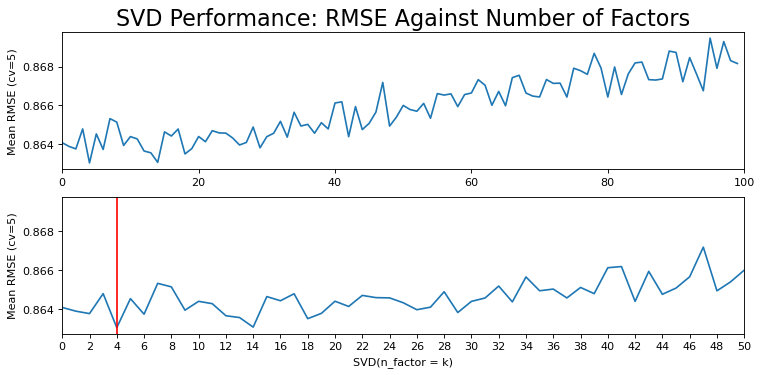

In [7]:
def plot_rmse(rmse, algorithm):
  """Returns: sub plots (2x1) of rmse against number of factors. 
     Vertical line in the second subplot identifies the arg for minimum RMSE
    
     Arg: i.) rmse = list of mean RMSE returned by rmse_vs_factors(), ii.) algorithm = STRING! of algo 
  """
  
  plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

  plt.subplot(2,1,1)
  plt.plot(rmse)
  plt.xlim(0,100)
  plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
  plt.ylabel("Mean RMSE (cv=5)")

  plt.subplot(2,1,2)
  plt.plot(rmse)
  plt.xlim(0,50)
  plt.xticks(np.arange(0, 52, step=2))

  plt.xlabel("{0}(n_factor = k)".format(algorithm))
  plt.ylabel("Mean RMSE (cv=5)")
  plt.axvline(np.argmin(rmse), color = "r")

plot_rmse(rmse_svd,"SVD")


###### According to the figure, there is an increasing trend of worse performance with higher k. The lowest RMSE is achieved when k=4. 

In [8]:
param_grid = {'n_factors': [4,6,9,11,14,18,29]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)


# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8633595626314179
{'n_factors': 18}


To make the model generalizable, i.e. avoid over and underfitting, the grid algorithm finds n_factors = 11 optimal.

## Training SVD Algorithm and Predictions

Next, SVD(n_factors = 11) fits the model on trainset.

In [9]:
algo_SVD = SVD(n_factors = 11)
algo_SVD.fit(trainset)


# Predict ratings for all pairs (i,j) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = algo_SVD.test(testset)

# subset of the list  predictions
predictions[0:2]

#[Prediction(uid=1, iid=318, r_ui=3.5110432282575212, est=5, details={'was_impossible': False}),
# Prediction(uid=1, iid=1704, r_ui=3.5110432282575212, est=4.953822490465707, details={'was_impossible': False})]

[Prediction(uid=1, iid=318, r_ui=3.5110432282575212, est=5, details={'was_impossible': False}),
 Prediction(uid=1, iid=1704, r_ui=3.5110432282575212, est=4.881429569312792, details={'was_impossible': False})]

In [10]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    #Peart I.: Surprise docomuntation
    
    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    #Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
    
    
    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
            
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
    (movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
    
    
    return hist_usr, pred_usr

In [1]:
hist_SVD_124, pred_SVD_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)

In [ ]:
hist_SVD_124.head(15)

When it comes to predictions, the outcome is stored in the same order and format as the user's history.

In [ ]:
pred_SVD_124

Comparing the predictions with history, one can observe that the genres are in line with the user's taste.

## Non-Negative Matrix Factorization (NMF)


In [ ]:
rmse_nmf = rmse_vs_factors(NMF, data)

In [ ]:
plot_rmse(rmse_nmf, "NMF")

In [ ]:
param_grid = {'n_factors': [11,14,15,16,17,18,20]}
gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=5)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [ ]:
0.8861525979842921
{'n_factors': 17}

In [ ]:
algo_NMF = NMF(n_factors = 16)
algo_NMF.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo_NMF.test(testset)

In [ ]:
hist_NMF_124, pred_NMF_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, original_ratings_df = ratings_df)

In [ ]:
Result: 
User 124 has already rated 50 movies.

In [ ]:
pred_NMF_124